In [1]:
import numpy as np
import matplotlib.pylab as plt
import random
import copy
import pandas
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

X = []
Y = []
for b in range(1, 5):
    D = unpickle('./cifar-10-batches-py/data_batch_%s' % b)
    X.append( D[b'data'].reshape((-1, 3, 32, 32)).astype('uint8') )
    Y.append( np.array(D[b'labels']))
X = np.vstack(X)
Y = np.hstack(Y).astype('int')

D = unpickle('./cifar-10-batches-py/test_batch')
Xt = D[b'data'].reshape((-1, 3, 32, 32)).astype('uint8')
Yt = np.array(D[b'labels']).astype('int')
Lt = D[b'filenames']

In [4]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.bn1 = torch.nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(3, 20, 3)
        
        self.bn2 = torch.nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 40, 3)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.bn3 = torch.nn.BatchNorm2d(40)
        self.conv3 = nn.Conv2d(40, 80, 3)
        
        self.bn4 = torch.nn.BatchNorm2d(80)
        self.conv4 = nn.Conv2d(80, 40, 1)
        
        self.fc1 = nn.Linear(40 * 6 * 6, 10)
        
        self.dropout = nn.Dropout2d(p=0.4)
        self.out = nn.LogSoftmax()

    def forward(self, x):
        x = self.bn1(x)
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.bn2(x)
        x = self.conv2(x)
        x = F.relu(x)

        x = self.pool(x)
        
        x = self.bn3(x)
        x = self.conv3(x)
        x = F.relu(x)
        
        x = self.bn4(x)
        x = self.conv4(x)
        x = F.relu(x)
        
        x = self.pool(x)      
        
        x = x.view(-1, 40 * 6 * 6)
        x = F.relu(self.fc1(self.dropout(x)))
        
        return self.out(x)


net = Net().cuda()
print(net)

Net (
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (bn3): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d(80, 40, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear (1440 -> 10)
  (dropout): Dropout2d (p=0.4)
  (out): LogSoftmax ()
)


Done epoch 0 with loss 75.31276845932007
Done epoch 1 with loss 62.5228431224823
Done epoch 2 with loss 58.10370874404907
Done epoch 3 with loss 55.23558866977692
Done epoch 4 with loss 52.6036182641983
Done epoch 5 with loss 50.82488131523132
Done epoch 6 with loss 49.06254208087921
Done epoch 7 with loss 47.65251874923706
Done epoch 8 with loss 46.625537395477295
Done epoch 9 with loss 45.59684956073761
Done epoch 10 with loss 44.71550267934799
Done epoch 11 with loss 43.85742449760437
Done epoch 12 with loss 43.11403179168701
Done epoch 13 with loss 42.50301259756088
Done epoch 14 with loss 41.86160343885422
Done epoch 15 with loss 41.31113928556442
Done epoch 16 with loss 40.88734608888626
Done epoch 17 with loss 40.352033734321594
Done epoch 18 with loss 39.901476979255676
Done epoch 19 with loss 39.42467415332794
Done epoch 20 with loss 39.07567584514618
Done epoch 21 with loss 38.85837197303772
Done epoch 22 with loss 37.95506000518799
Done epoch 23 with loss 37.82640993595123
D

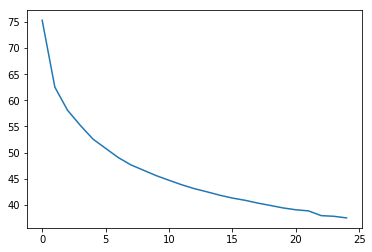

In [5]:
%%timeit -n 1 -r 1

loss_fn = torch.nn.NLLLoss().cuda()

learning_rate = 1e-3
batch_size = 1000
loss_curve = []

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

for iter in range(25):
    Xperm = np.random.permutation(X.shape[0])
    loss_acc = 0
    for b in range(X.shape[0]//batch_size):
        batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
        x = Variable(torch.Tensor(X[batch_idxs].tolist())).cuda()
        y = Variable(torch.LongTensor(Y[batch_idxs])).cuda()
        y_pred = net(x)
              
        loss = loss_fn(y_pred, y)
        loss_acc += loss.data[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Done epoch %s with loss %s' % (iter, loss_acc))
    loss_curve.append(loss_acc)
    
plt.plot(loss_curve)

In [6]:
net_parameters = net.state_dict()
import pickle
with open('./cnn_without_full_connection_1_25.pkl', 'wb') as f:
    pickle.dump(net_parameters, f)

In [7]:
import pickle
with open('./cnn_without_full_connection_1_25.pkl', 'rb') as f:
    result_nets = pickle.load(f)

net.load_state_dict(result_nets)

In [8]:
net.load_state_dict(result_nets)
net.train(False)
x = Variable(torch.Tensor(Xt.tolist())).cuda()
y = Variable(torch.LongTensor(Yt)).cuda()
batch_size=2000
loss_acc=0
Xperm = np.random.permutation(Xt.shape[0])
loss_fn = torch.nn.NLLLoss().cuda()
for b in range(Xt.shape[0]//batch_size):
        batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
        x = Variable(torch.Tensor(Xt[batch_idxs].tolist()), volatile=True).cuda()
        y = Variable(torch.LongTensor(Yt[batch_idxs]), volatile=True).cuda()
        y_pred = net(x)
              
        loss = loss_fn(y_pred, y)
        loss_acc += loss.data[0]
print( loss_acc / 5 )

1.0482588052749633


In [19]:
net.load_state_dict(result_nets)
net.train(False)
x = Variable(torch.Tensor(Xt.tolist())).cuda()
y = Variable(torch.LongTensor(Yt)).cuda()
batch_size=5000
loss_acc=0
loss_fn = torch.nn.NLLLoss().cuda()
for b in range(1,2):
        x = Variable(torch.Tensor(Xt[b*batch_size:(b+1)*batch_size].tolist()), volatile=True).cuda()
        y = Variable(torch.LongTensor(Yt[b*batch_size:(b+1)*batch_size]), volatile=True).cuda()
        y_pred = net(x)
              
        loss = loss_fn(y_pred, y)
        loss_acc += loss.data[0]
print( loss_acc / 2 )

0.31412509083747864


In [20]:
d = pandas.DataFrame()
yt = Yt #.data.cpu().numpy() #
d['id'] = range(1, len(yt)+1)
for i in range(10):
    y = np.zeros((len(Lt),), dtype='int')
    y[yt == i] = 1
    d['c%s' % i] = y

In [21]:
d.to_csv('./ground.csv', index=False)

In [22]:
%%bash
head ./ground.csv
tail ./ground.csv

id,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
1,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,1,0,0,0
7,0,1,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,0
9,0,0,0,1,0,0,0,0,0,0
9991,0,0,0,0,0,0,0,1,0,0
9992,1,0,0,0,0,0,0,0,0,0
9993,0,0,0,1,0,0,0,0,0,0
9994,0,0,0,0,0,1,0,0,0,0
9995,0,0,0,1,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,1,0
9997,0,0,0,1,0,0,0,0,0,0
9998,0,0,0,0,0,1,0,0,0,0
9999,0,1,0,0,0,0,0,0,0,0
10000,0,0,0,0,0,0,0,1,0,0


In [24]:
d = pandas.DataFrame()
d['id'] = range(len(yt))
yt = y_pred.data.cpu().numpy()
for i in range(10):
    d['c%s' % i] = np.exp(yt[:, i])

In [25]:
d.to_csv('./simple_cnn2.csv', index=False)